# Exempel på:   
- Bollinger features samt plot  
- nya bättre predctors (features)  
- backtesting  

In [3]:
import yfinance as yf
import ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


## Get the ticker

In [4]:
df = pd.DataFrame()
ticker = "ETH-USD"
# ticker = "TSLA-USD"

# if os.path.exists(ticker+".csv"):
#     print('använd sparad fil')
#     df = pd.read_csv(ticker+".csv", index_col=0)
# else:
df = yf.download(ticker,period='max')  #  tex: start="2019-01-01", end="2020-01-01")
df.to_csv(ticker+".csv")

df.index = pd.to_datetime(df.index)
df.tail(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-09-05,1577.884033,1621.661377,1559.781860,1617.183228,1617.183228,13060541168
2022-09-06,1617.240234,1680.595337,1561.748535,1561.748535,1561.748535,22946059125
2022-09-07,1560.906738,1651.051147,1500.013672,1629.906372,1629.906372,19560363854
2022-09-08,1629.805176,1655.064087,1603.063843,1635.347656,1635.347656,17621046717
2022-09-09,1635.187744,1735.809814,1632.836548,1719.085449,1719.085449,20242323690
2022-09-10,1718.961304,1784.497803,1710.296997,1776.203735,1776.203735,13130928217
2022-09-11,1775.976074,1782.729858,1730.164795,1761.800049,1761.800049,12464301922
2022-09-12,1762.084839,1778.163452,1698.293457,1713.765259,1713.765259,17688391310
2022-09-13,1713.962524,1745.779053,1564.031860,1580.787964,1580.787964,23066821734


<AxesSubplot:xlabel='Date'>

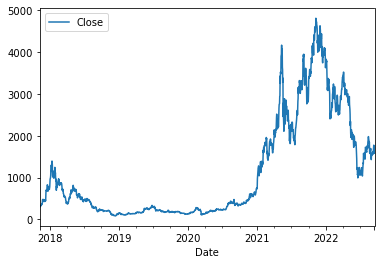

In [5]:
df.plot.line(y="Close") #, use_index=True)

## Compute Bollinger bands

In [6]:
from ta.volatility import BollingerBands
    
def add_bolinger_bands(df):
    # df.dropna(inplace=True)

    # Initialize Bollinger Bands Indicator
    indicator_bb = BollingerBands(close=df["Close"], window=20, window_dev=2)

    df['bb_bbm'] = indicator_bb.bollinger_mavg()
    df['bb_bbh'] = indicator_bb.bollinger_hband()
    df['bb_bbl'] = indicator_bb.bollinger_lband()

    # Add Bollinger Band high indicator
    df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

    # Add Bollinger Band low indicator
    df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

    df['Sell'] = ((df['Close'] > df['bb_bbh']) & (df['stoch_k'] > 0.95))*1
    df['Buy'] = ((df['Close'] < df['bb_bbl']) & (df['stoch_k'] < 0.05))*1

    df.dropna(inplace=True)


## Set predictors and target 

In [7]:
def indicators(df, bollinger=True):
    df['SMA_180'] = ta.trend.sma_indicator(df['Close'], window=180)
    df['stoch_k'] = ta.momentum.stochrsi_k(df['Close'], window=10)
 
    # Target    
    df['Tomorrow'] = df['Close'].shift(-1)   # to tomorrow's close price - alltså nästa dag
    df['y'] = (df['Tomorrow'] > df['Close']).astype(int)
    df.dropna(inplace=True)
    predictors = ['Open','High', 'Low', 'Close', 'Volume', 'SMA_180', 'stoch_k'] # columns to use as features
    if bollinger:
        add_bolinger_bands(df)
        predictors += ['bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_bbhi', 'bb_bbli', 'Sell', 'Buy'] # lägg till bollinge kolumner
    return predictors
        

In [8]:
predictors=indicators(df, bollinger = True)

df.tail(3)

,Open,High,Low,Close,Adj Close,Volume,SMA_180,stoch_k,Tomorrow,y,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,Sell,Buy
Date,,,,,,,,,,,,,,,,,
2022-09-11,1775.976074,1782.729858,1730.164795,1761.800049,1761.800049,12464301922,2023.959274,0.968060,1713.765259,0,1603.787952,1779.149083,1428.426820,0.0,0.0,0,0
2022-09-12,1762.084839,1778.163452,1698.293457,1713.765259,1713.765259,17688391310,2018.079882,0.833717,1580.787964,0,1606.337720,1786.473082,1426.202357,0.0,0.0,0,0
2022-09-13,1713.962524,1745.779053,1564.031860,1580.787964,1580.787964,23066821734,2011.223957,0.500384,1587.135010,1,1602.524158,1781.428042,1423.620273,0.0,0.0,0,0


## Plot exempel (med fejkad predict)

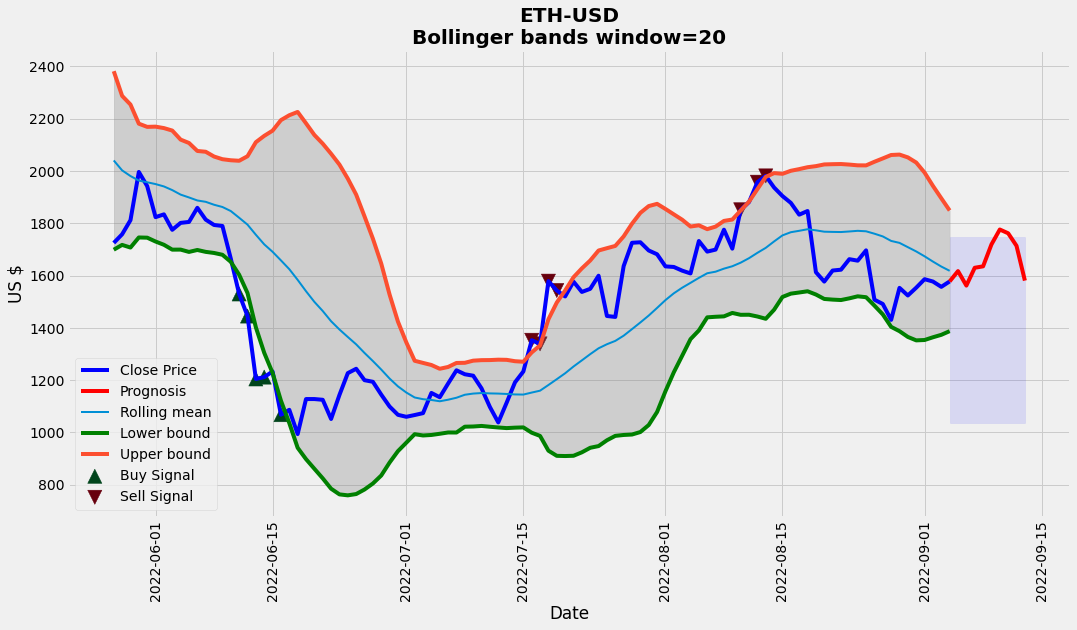

In [9]:
# Plot exempel matplotlib

import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

###############################################
### jag fejkar här att det finns en prognos ###
###############################################
antal_ticks = 100 # number of ticks to plot
antal_prognos = 10 # number of ticks predicted
df_prognos = df[-antal_prognos:] # get fejkade prognos ticks
# get the last antal_ticks before that (the real ticks)
df_ticks = df[-(antal_ticks+antal_prognos):-antal_prognos+1]
########### fejk end ###########################

### define plot area width=16 height=8 ###
fig, ax = plt.subplots(figsize=(16,8))

### create the plot to be modified ###
ax.plot(df_ticks['Close'], label='Close Price', linewidth=4, color='blue')    
ax.plot(df_prognos['Close'], label='Prognosis', linewidth=4, color='red') 

#### now modify the plot before showing it

### sätta egna ticks möjligt men inte nödvändigt då plt sköter det bättre själv ###
# ticks = df.index.values[::90]     
# tick_labels=[tick.year for tick in ticks]
# plt.xticks(ticks, rotation=90)
# ax.set_xticklabels(tick_labels)

ax.plot(df_ticks['bb_bbm'], label='Rolling mean', linewidth=2)   # plot another line in the same fig
ax.plot(df_ticks['bb_bbl'], label='Lower bound', linewidth=4, color='g')   # plot another line in the same fig
# plot another line in the same fig
ax.plot(df_ticks['bb_bbh'], label='Upper bound', linewidth=4)

### add buy /sell signals ###
df_Buy  = df_ticks.query('Close < bb_bbl')
df_Sell = df_ticks.query('Close > bb_bbh')
ax.scatter(df_Buy.index, df_Buy['Close'], s = 200, c=df_Buy['bb_bbli'], cmap='Greens_r', 
            label='Buy Signal', marker='^', alpha=1)
ax.scatter(df_Sell.index, df_Sell['Close'], s= 200, c=df_Sell['bb_bbhi'], cmap='Reds_r',
            label='Sell Signal', marker='v', alpha=1)

plt.xticks(rotation=90)

### super title ###
# plt.suptitle('ETH-USD Bollinger bands',fontsize=20, fontweight='bold')

### title ###
plt.title('ETH-USD\nBollinger bands window=20',fontsize=20,fontweight='bold')

### grey bollinger area between bands ###
ax.fill_between(df_ticks.index, df_ticks['bb_bbl'], df_ticks['bb_bbh'], color='grey', alpha=0.3)

### highlight the prognosis are ###
#ax.fill_between(df_prognos.index, df_prognos['bb_bbl'], df_prognos['bb_bbh'], color='blue', alpha=0.3)
ax.axvspan(xmin=df_prognos.index[0], xmax=df_prognos.index[-1], ymin=0.2, ymax=0.6,color='blue', alpha=0.1)
ax.set_xlabel("Date")
ax.set_ylabel("US $")
ax.legend()   # parametrar tex. (loc='upper left', fontsize=16)
plt.show()

## Start with ML

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

In [11]:
# df.index = pd.to_datetime(df.index)

In [12]:
df.y.value_counts()

1    809
0    763
Name: y, dtype: int64

In [13]:
rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=2022)

train = df.iloc[:-100]
test = df.iloc[-100:]

rf.fit(train[predictors], train["y"])


RandomForestClassifier(min_samples_split=10, random_state=2022)

### En full omgång fit + predict
Returnerar en df med kolumnerna true_y och pred_y

<AxesSubplot:title={'center':'Predictions vs true values (y)'}, xlabel='Date'>

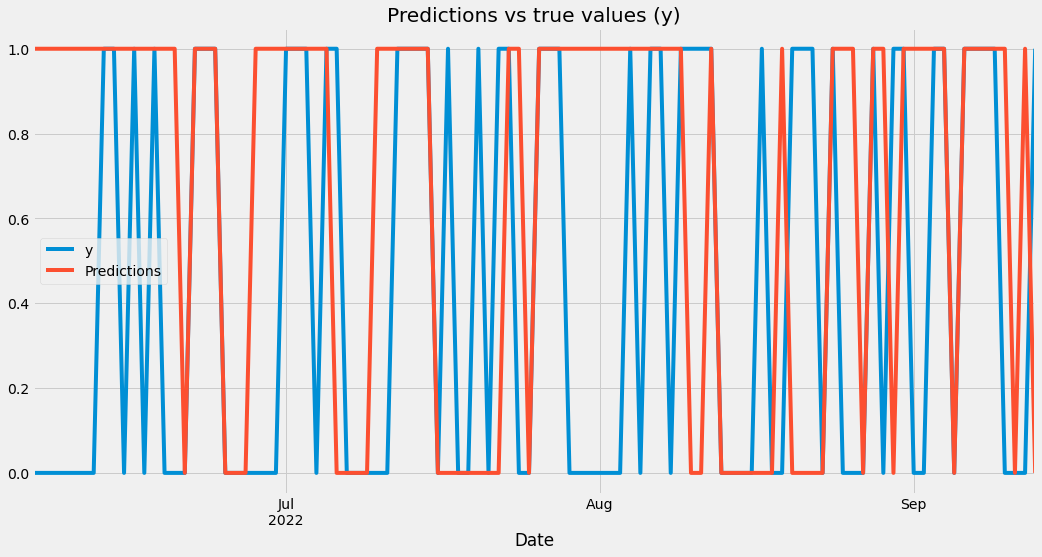

In [14]:

def fit_predict(train, test, predictors, model, proba_val=None):
    model.fit(train[predictors], train["y"])
    
    if proba_val: # använd proba
        preds = model.predict_proba(test[predictors])[:,1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])
        
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["y"], preds], axis=1)
    
    return combined

combined=fit_predict(train, test, predictors, rf, proba_val=0.6)
combined.plot( figsize=(16, 8), title="Predictions vs true values (y)")
    


### En back test för tidsserier

In [15]:
def backtest(data, model, predictors, proba_val=0.6, start=180, step=7):
    """"
    Args:
        data (DataFrame): Data to use for backtesting
        model: Tex RandomForestClassifier
        predictors: Features in data to use for backtesting
        proba_val (float): threshold för att få 1 annars 0 i predictions.
        start (int, optional): Hur många rader in i data skall vi starta testet. Defaults to 180.
        step (int, optional): Hur många rader skall vi ta i varje batch framåt. Defaults to 60.

    Returns:
        DataFrame: Två kolumner med true_y och prediktioner 
    """
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = fit_predict(train, test, predictors, model, proba_val=proba_val)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


In [16]:
# # cross validation funkar inte bra med timeseries
# scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='precision')
# scores.mean()
predictions1 = backtest(df, rf, predictors, proba_val=0.6, step=7)

predictions1.query('y==Predictions and y==1').shape[0]
predictions1["Predictions"].value_counts()
first_try = precision_score(predictions1["y"], predictions1["Predictions"])
print(f"Precision: {first_try:.4f}")
predictions1["y"].value_counts() / predictions1.shape[0]


Precision: 0.5099


1    0.525862
0    0.474138
Name: y, dtype: float64

### Beräkna nya (bättre) predictors
Vi utelämnar bollinger parms tills vidare och använder bara close

In [17]:
# tidsintervall i dagar för rullande medelvärden
horizons = [2, 5, 60, 250]  # skulle helst ha med upp till 4 år men ETH har för få värden
new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()["y"]

    new_predictors += [ratio_column, trend_column]
    
df = df.dropna()

df[new_predictors].head(3)


,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250
Date,,,,,,,,
2019-01-31,0.991450,1.0,0.988446,1.0,0.902538,30.0,0.390674,111.0
2019-02-01,1.002556,1.0,1.004260,2.0,0.907332,31.0,0.395361,112.0
2019-02-02,1.012936,2.0,1.023247,3.0,0.931085,31.0,0.408156,113.0


In [20]:
df[['SMA_180', 'stoch_k', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_bbhi',
       'bb_bbli', 'Sell', 'Buy', ]]

,SMA_180,stoch_k,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,Sell,Buy
Date,,,,,,,,,
2019-01-31,189.339952,0.315066,117.570444,130.466719,104.674169,0.0,0.0,0,0
2019-02-01,187.657139,0.496205,116.652607,129.640612,103.664601,0.0,0.0,0,0
2019-02-02,186.011430,0.646865,116.329229,129.595785,103.062674,0.0,0.0,0,0
2019-02-03,184.496306,0.743768,115.250426,127.680400,102.820453,0.0,0.0,0,0
2019-02-04,183.114131,0.812285,114.539871,126.962523,102.117219,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...
2022-09-09,2033.252840,1.000000,1588.979004,1727.013840,1450.944167,0.0,0.0,0,0
2022-09-10,2028.727883,1.000000,1596.823242,1756.929473,1436.717011,1.0,0.0,1,0
2022-09-11,2023.959274,0.968060,1603.787952,1779.149083,1428.426820,0.0,0.0,0,0


Blir modellen bättre?

In [16]:
# Förbättrad backtestning
rf = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

predictions2 = backtest(df, rf, new_predictors, proba_val=0.6, step=7)

print("New precision_score:\t", round(precision_score(predictions2["y"], predictions2["Predictions"]),4), '\nFirst_try:\t\t', round(first_try,4))

# print(f'{predictions["y"].value_counts() / predictions.shape[0]}')


New precision_score:	 0.5535 
First_try:		 0.5099


In [17]:
predictions2.Predictions = predictions2.Predictions.astype(int)
second_try = precision_score(predictions2["y"], predictions2["Predictions"])

predictions2.value_counts()

y  Predictions
1  0              425
0  0              399
1  1              176
0  1              142
dtype: int64

Confusion matrix

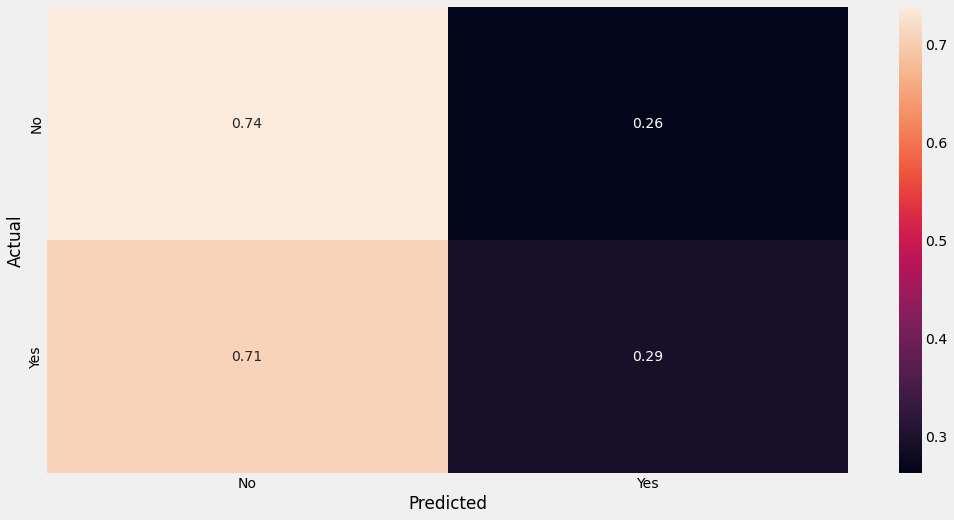

In [18]:
import seaborn as sns

def confusion(y_true, y_pred, labels=['Sell', 'Buy']):
    # plot the confusion matrix mha seaborn heatmap
    cm = confusion_matrix(y_true, y_pred)
    cm = cm/cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(16, 8))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
confusion(predictions2["y"], predictions2["Predictions"])


Gör en GridSearch på modeller och parametrar

In [40]:

# Gridsearch

import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import TimeSeriesSplit
rf = RandomForestClassifier(random_state=1)
et = ExtraTreesClassifier(random_state=1)
knn = KNeighborsClassifier()
xgb = XGBClassifier(random_state=1, n_jobs=-1)
ridge = RidgeClassifier(     )
tscv = TimeSeriesSplit(n_splits=5)
def grid_search(X, y, scoring='precision'):
    grid_parms = {
        'xgb': {
            
            'model': xgb,
            'params': {
                    'learning_rate' : [0.01, 0.3,0.5, 3],
                    # 'L1' : [0.1,0.5,1],
                    # 'L2' :  [0.1,0.5,1],  
                    'n_estimators' : [50, 100, 200, 500],
                    'max_depth' : [ 7, 10,15],
                    'min_child_weight' : [1, 3],
                    'gamma' : [0.3,0.5, 0.7],
                    'subsample' : [0.6, 1.0],
            }
            
        },
        'et': {
            'model': et,
            'params': {
                    'n_estimators': [100, 200, 1000],
                    'min_samples_split': [5, 10, 20, 50]
            }
        },
        'rf': {
            'model': rf,
            'params': {
                    'n_estimators': [1000, 2000, 3000],
                    'min_samples_split': [10, 20, 50, 100]
            }
        },
        'knn': {
            'model': knn,
            'params': {
                'n_neighbors': [2,3, 5, 8]
            }
        },
        'ridge': {
            'model': ridge,
            'params': {
                    'alpha': [0.1, 0.5, 1, 10, 100]
            }
        }
    }
    scores = []
    tscv = TimeSeriesSplit(n_splits=5)

    for model_name, config in grid_parms.items():
        print(model_name, config['params'])
        
        gs = GridSearchCV(config['model'], config['params'], scoring='precision',n_jobs=-1,
                            cv=tscv, return_train_score=False, verbose=3)
        gs.fit(X, y)
        scores.append({
            'model': model_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
        
        pd.options.display.max_columns = 200    # default 20
        pd.options.display.max_colwidth = 180  # default 50
        df_grid = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params']).sort_values(
                        by='best_score', ascending=False)
        
    return df_grid     

df_grid = grid_search(df[new_predictors], df.y)

pickle.dump(df_grid, open('df_grid.sav', 'wb'))


xgb {'learning_rate': [0.01, 0.3, 0.5, 3], 'n_estimators': [50, 100, 200, 500], 'max_depth': [7, 10, 15], 'min_child_weight': [1, 3], 'gamma': [0.3, 0.5, 0.7], 'subsample': [0.6, 1.0]}
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
et {'n_estimators': [100, 200, 1000], 'min_samples_split': [5, 10, 20, 50]}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
rf {'n_estimators': [1000, 2000, 3000], 'min_samples_split': [10, 20, 50, 100]}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
knn {'n_neighbors': [2, 3, 5, 8]}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
ridge {'alpha': [0.1, 0.5, 1, 10, 100]}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


UnpicklingError: invalid load key, 'm'.

In [42]:
df_grid

,model,best_score,best_params
0,xgb,0.638037,"{'gamma': 0.3, 'learning_rate': 3, 'max_depth': 15, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 0.6}"
3,knn,0.570888,{'n_neighbors': 2}
2,rf,0.570800,"{'min_samples_split': 20, 'n_estimators': 2000}"
4,ridge,0.566353,{'alpha': 1}
1,et,0.560162,"{'min_samples_split': 20, 'n_estimators': 100}"


In [48]:
df_grid = pickle.load(open('df_grid.sav', 'rb'))

best_model = df_grid.iloc[0].model
best_params = df_grid.iloc[0].best_params
print(best_model)
display(best_params)

xgb


{'gamma': 0.3,
 'learning_rate': 3,
 'max_depth': 15,
 'min_child_weight': 3,
 'n_estimators': 50,
 'subsample': 0.6}

In [49]:
knn_model = df_grid.query('model == "knn"').model.values[0]
knn_params = df_grid.query('model == "knn"').best_params.values[0]
print(knn_model, knn_params)
# from xgboost import XGBClassifier
knn = KNeighborsClassifier(**knn_params)

predictions_knn = backtest(df, xgb, new_predictors, proba_val= 0.6, step=7)

print("knn precision_score:\t", round(precision_score(predictions_knn["y"], predictions_knn["Predictions"]),4))
print('First_try:\t\t', round(first_try,4), '\nSecond_try:\t\t', round(second_try,4))
predictions_knn.value_counts()

knn {'n_neighbors': 2}
knn precision_score:	 0.5343
First_try:		 0.5099 
Second_try:		 0.5535


y  Predictions
1  0.0            313
0  0.0            290
1  1.0            288
0  1.0            251
dtype: int64

### XGBoost vann ganska stort!
Kolla också CatBoost och ratio samt trens även för (vissa) Bollinger features

In [50]:
xgb_model = df_grid.query('model == "xgb"').best_params.values[0]
xgb_params = df_grid.query('model == "xgb"').best_params.values[0]
from xgboost import XGBClassifier
xgb = XGBClassifier(**xgb_params)

predictions3 = backtest(df, xgb, new_predictors, proba_val= 0.6, step=7)

print("xgb precision_score:\t", round(precision_score(predictions3["y"], predictions3["Predictions"]),4))
print('First_try:\t\t', round(first_try,4), '\nSecond_try:\t\t', round(second_try,4))
predictions3.value_counts()


xgb precision_score:	 0.529
First_try:		 0.5099 
Second_try:		 0.5535


y  Predictions
1  1.0            328
0  1.0            292
1  0.0            273
0  0.0            249
dtype: int64

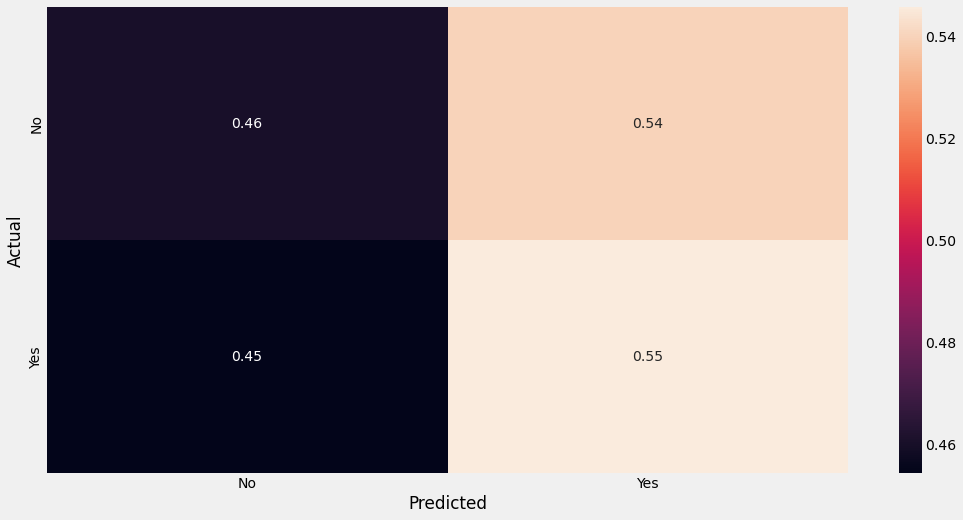

In [51]:
predictions3.Predictions = predictions3.Predictions.astype(int)
predictions3.value_counts()
confusion(predictions3["y"], predictions3["Predictions"])

In [66]:
from datetime import timedelta
print(f'Låt {df.index.max().strftime("%Y-%m-%d")} ge prognos för {(df.index.max() + timedelta(days=1)).strftime("%Y-%m-%d")}')

proba_val=0.6
# xgb.fit(df[new_predictors].iloc[:-1], df.iloc[:-1].y)
preds = xgb.predict_proba(df.iloc[-1:][new_predictors])[:, 1]
preds[preds >= proba_val] = 1
preds[preds < proba_val] = 0
print(preds[0].astype(int),df.iloc[-1:].y[0])
print('Korrekt!' if preds[0].astype(int) == df.iloc[-1:].y[0] else 'Fel!')



Låt 2022-09-13 ge prognos för 2022-09-14
1 1
Korrekt
